# test notebook for stella ZAMS calc code

In [33]:
# imports
import numpy as np

import ray
from ray.util.multiprocessing import Pool

import pandas as pd
from scipy import optimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interpn

# from jax import grad, jit
# from jax import jacfwd, jacrev
# from jax.numpy import linalg

# from jax.config import config
# config.update("jax_enable_x64", True)

# constants
import constants as c
from scipy.constants import N_A

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('default')
sb.set_context("talk")
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

In [31]:
import interpolate
import energy
import density

Read Sections 18.0, 18.1, and 18.2 of Numerical Recipes, as it will be necessary
to implement the method of shooting to a fitting point (their shootf function) to
solve the boundary-value problem posed by the four coupled ordinary differential
equations of stellar structure and evolution. You will also need a program similar
to the newt function described in Section 9.7 of Numerical Recipes or in the
SciPy documentation to repeatedly call a shootf-like function, calculate updated
boundary values, and ultimately obtain a converged solution. Faster convergence
can usually be obtained by using fractions of the updates suggested by a newt-
like function. Ordinary differential equation (ODE) solvers like those described
in Sections 17.0, 17.1, and 17.2 of Numerical Recipes or the SciPy documentation
are also critical.

In [24]:
def load_inner(Tc, Pc, factor=1e-12):
    """
    Returns reasonable guess for an integration
    starting point exterior to the absolute center
    """
    rho_c = density.density(Pc,Tc, X=0.7)

    m = factor*c.Ms # set start just outside center
    epsilon = energy.energy_gen(rho_c,Tc)
    l = epsilon*m # determine energy generation from pp and CNO
    
    r = (3/(4*np.pi*rho_c))**(1/3) * m**(1/3) # radius start
    
    P = Pc - (3*c.G/(8*np.pi))*((4*np.pi*rho_c/3)**(4/3))*(m**(2/3))
    
    del_rad = energy.del_rad(m, l, P, rho_c, Tc)
    if del_rad > energy.del_ad:
#         print('convective core')
        lnT = np.log(Tc) - (np.pi/6)**(1/3)*c.G*(energy.del_ad*rho_c**(4/3))/Pc*m**(2/3)
        T = np.exp(lnT)
    else:
#         print('radiative core')
        kappa_c = interpolate.interp_k(rho_c,Tc)
        T = (Tc**4 - (1/(2*c.a*c.c)*(3/(4*np.pi))**(2/3)*kappa_c*epsilon*rho_c**(4/3)*m**(2/3)))**(1/4)
    
    return np.array([l, P, r, T])

def load_outer(M_star, L_star, R_star, factor=0.9999):
    """
    Returns reasonable guess for an integration
    starting point interior to the photosphere.
    """
    
    mu = 4/(3+5*0.7)
    surface_g = c.G*M_star/(R_star**2)
    Teff = (L_star/(4*np.pi*c.sb*R_star**2))**(1/4)
    
    def min_rho(rho):
        kappa = interpolate.interp_k(rho,Teff) 
        # eq. 4.48 in HKT
        opacity_pressure = (2/3) * (surface_g / kappa) * (1 + (kappa*L_star/(4*np.pi*c.c*c.G*M_star)))
        gas_rad_pressure = (1/3)*c.a*Teff**4 + rho * N_A*c.k*Teff/mu
        diff = 1 - opacity_pressure/gas_rad_pressure
        return np.abs(diff**2)
    
    rho_sol = optimize.minimize(min_rho, 1e-8, args=(), method='Nelder-Mead', bounds=[(1e-13,1e-5)])
    if rho_sol.success:
        rho = rho_sol.x[0]
    else:
        print('there\'s no rho for this Teff, log(g)')
        rho = np.nan
    kappa = interpolate.interp_k(rho,Teff)
    P = 2*surface_g/(3*kappa)
    
    return np.array([L_star, P, R_star, Teff])


def odeEZ(m,v):
    l, P, r, T = v
    rho = density.density(P,T, X=0.7) # density
    del_radiative = energy.del_rad(m, l, P, rho, T)
    del_actual = np.minimum(del_radiative, energy.del_ad)
    
    dldm = energy.energy_gen(rho,T, psi=1) #change in Luminosity with enclosed mass
    dPdm = -c.G*m/(4*np.pi*r**4) # change in pressure with enclosed mass
    drdm = 1/(4*np.pi*r**2 * rho) # mass conservation eq.
    dTdm = ((-c.G*m*T)/(4*np.pi*P*r**4))*del_actual # change in temperature with enclosed mass
    
    return np.array([dldm, dPdm, drdm, dTdm])
    

In [25]:
def shooter(vec, M_star=1.0*c.Ms,  n=int(1e5), in_factor=1e-12, out_factor=0.9999, M_fit=0.5):
    
    L_star, Pc, R_star, Tc = vec
    
#     print(vec)
    
    inn = load_inner(Tc, Pc, factor=in_factor)
    outt = load_outer(M_star, L_star, R_star, factor=out_factor)
    
#     print(inn)
#     print(outt)
    
    # protect against low Teff solutions which crash the root finder
    if np.isnan(np.sum(inn)) or np.isnan(np.sum(outt)):
        print('caught a nan in the guess')
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        return np.array([dL, dP, dR, dT])


    exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
    entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

    ray.init(num_cpus=4)
    pool = Pool()
    
    sol_i = pool.apply(solve_ivp, [odeEZ, (exiting[0], exiting[-1]), inn, 'RK45', exiting])
#     sol_i = solve_ivp(odeEZ, (exiting[0], exiting[-1]), inn, method='RK45', t_eval=exiting) 
    if sol_i.status == 0:
        print('solved inner')
    else:
        print('failed to solve interior', sol_i.message)
        ray.shutdown()
#         raise ValueError
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        ray.shutdown()
        return np.array([dL, dP, dR, dT])
    sol_s = pool.apply(solve_ivp, [odeEZ, (entering[0], entering[-1]), outt, 'RK45', entering])
    if sol_s.status == 0:
        ray.shutdown()
        print('solved exterior')
    else:
        print('failed to solve exterior', sol_s.message)
#         ray.shutdown()
#         raise ValueError
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        ray.shutdown()
        return np.array([dL, dP, dR, dT])
    
    exiting_sol = sol_i.y
    entering_sol = sol_s.y
    
#     print(exiting_sol)
#     print(entering_sol)

    dL = (exiting_sol[0,-1] - entering_sol[0,-1])/L_star
    dP = (exiting_sol[1,-1] - entering_sol[1,-1])/Pc
    dR = (exiting_sol[2,-1] - entering_sol[2,-1])/R_star
    dT = (exiting_sol[3,-1] - entering_sol[3,-1])/Tc
    
    res = np.array([dL, dP, dR, dT])
    
    print(res)
    print(np.sum(np.abs(res)))

    return res

In [26]:
def solver(vec_final, M_star=1.0*c.Ms,  n=int(1e5), in_factor=1e-12, out_factor=0.9999, M_fit=0.5):
    
    L_star, Pc, R_star, Tc = vec_final
    
    inn = load_inner(Tc, Pc, factor=in_factor)
    outt = load_outer(M_star, L_star, R_star, factor=out_factor)

    exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
    entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

    ray.init(num_cpus=4)
    pool = Pool()
    
    sol_i = pool.apply(solve_ivp, [odeEZ, (exiting[0], exiting[-1]), inn, 'RK45', exiting])
    sol_s = pool.apply(solve_ivp, [odeEZ, (entering[0], entering[-1]), outt, 'RK45', entering])
    
    ray.shutdown()
    
    exiting_sol = sol_i.y
    entering_sol = sol_s.y
    
    # combine mass arrays
    mass = np.concatenate([exiting, np.flipud(entering)], axis=0)
    
    # add mass to final array
    solution = np.zeros((7, mass.shape[0]))
    solution[0] = mass
    
    # combine solution arrays
    sols = np.concatenate([exiting_sol, np.fliplr(entering_sol)], axis=1)
    solution[1:5] = sols
    
    # add density as 6th column
    rho = density.density(solution[2],solution[4], X=0.7)
    solution[5] = rho
    
    # add del_rad as 7th column
#     del_rad = (3/(16*np.pi*c.a*c.c))*(solution[1]*interpolate.interp_k(rho, solution[3])/solution[3]**4)*(solution[0]/(c.G*mass))
    del_rad = energy.del_rad(mass, solution[1], solution[2], rho, solution[4])
    solution[6] = del_rad
    
    return solution

In [27]:
# surface
M_star = 1.67*c.Ms
L_star = (M_star/c.Ms)**(3.5)*c.Ls # eq. 1.88 HKT
R_star = (M_star/c.Ms)**(0.75)*c.Rs # eq. 1.87 HKT
# surface_guess = load_outer(M_star, L_star, R_star, factor=0.9999)
# core
# Pc = 2.65e17, sun
P_factor = 1e1 # guess to inflate constant density sphere pressure
Pc = (3/(8*np.pi))*(c.G*(M_star)**2)/(R_star)**4 * P_factor # constant density sphere, lower limit!
# Tc = 15e6, sun
Tc = (1/2)*((4/(3+5*0.7))/(N_A*c.k))*(c.G*M_star)/(R_star) # constant density sphere

vec = np.array([L_star, Pc, R_star, Tc])
args = (M_star, int(1e5), 1e-12, 0.9999, 0.25)

from scipy.optimize import least_squares, root

bounds = ([L_star*1e-1,Pc,R_star*1e-1,Tc], [L_star*1e2, Pc*1e4, R_star*1e1, Tc*1e3])
# bounds = [(L_star*1e-2,L_star*1e2),(Pc,Pc*1e2),(R_star*1e-2,R_star*1e2),(Tc,Tc*1e2)]

# x_scale = np.array([1e31, 1e14, 1e9, 1e6])

In [26]:
# todo, set x_scale for each variable to enable better tolerance estimate
final = least_squares(shooter, vec, args=args, bounds=bounds, 
                      method='dogbox', loss='arctan', 
                      gtol=1e-13, 
                      xtol=None, 
                      ftol=None, 
                      x_scale='jac', # x_scale
                     )

2023-04-18 22:07:04,416	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.90238284 -7.75536216  0.19478246 -0.5771289 ]
9.429656359566971


2023-04-18 22:07:24,054	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.90238284 -7.75536227  0.19478246 -0.57712891]
9.429656482987339


2023-04-18 22:07:41,673	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.90238284 -7.75536204  0.19478246 -0.5771289 ]
9.429656238716806


2023-04-18 22:08:01,185	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.90238285 -7.75536188  0.19478245 -0.57712889]
9.429656068940696


2023-04-18 22:08:18,792	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.90238284 -7.75536215  0.19478246 -0.57712888]
9.42965632818025


2023-04-18 22:08:41,153	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88790517 -7.52326852  0.21888383  0.02154245]
8.65159995971882


2023-04-18 22:09:01,412	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88790516 -7.52326863  0.21888383  0.02154245]
8.65160006616698


2023-04-18 22:09:18,389	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88790517 -7.5232684   0.21888382  0.02154245]
8.651599837905914


2023-04-18 22:09:35,891	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88790517 -7.52326823  0.21888382  0.02154246]
8.651599687774969


2023-04-18 22:09:53,795	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88790517 -7.52326851  0.21888383  0.02154247]
8.651599968253498


2023-04-18 22:10:13,502	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88814865 -7.52497242  0.21856827  0.01760431]
8.649293640270116


2023-04-18 22:10:33,419	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88814865 -7.52497253  0.21856827  0.0176043 ]
8.649293748426656


2023-04-18 22:10:50,578	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88814865 -7.5249723   0.21856826  0.01760431]
8.649293518467813


2023-04-18 22:11:07,861	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88814865 -7.52497214  0.21856826  0.01760432]
8.649293370054833


2023-04-18 22:11:25,354	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88814865 -7.52497241  0.21856827  0.01760433]
8.649293648852256


2023-04-18 22:11:42,480	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817511 -7.52515946  0.2185338   0.01717189]
8.649040267170994


2023-04-18 22:11:58,747	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817511 -7.52515957  0.2185338   0.01717189]
8.649040373634143


2023-04-18 22:12:16,116	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817511 -7.52515934  0.2185338   0.01717189]
8.649040145369806


2023-04-18 22:12:33,322	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817512 -7.52515918  0.2185338   0.0171719 ]
8.64903999531712


2023-04-18 22:12:50,651	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817511 -7.52515945  0.2185338   0.01717191]
8.649040275758324


2023-04-18 22:13:06,949	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817838 -7.52518263  0.21852955  0.01711853]
8.649009082532578


2023-04-18 22:13:23,183	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817837 -7.52518274  0.21852955  0.01711852]
8.649009192246998


2023-04-18 22:13:40,497	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817838 -7.52518251  0.21852955  0.01711853]
8.649008960731566


2023-04-18 22:13:56,586	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817838 -7.52518235  0.21852955  0.01711853]
8.649008812181254


2023-04-18 22:14:13,804	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88817837 -7.52518262  0.21852955  0.01711854]
8.649009091120572


2023-04-18 22:14:31,035	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88796812 -7.52618654  0.21877311  0.01968868]
8.652616462703122


2023-04-18 22:14:48,242	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88796812 -7.52618666  0.21877312  0.01968868]
8.652616574639465


2023-04-18 22:15:05,485	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88796812 -7.52618642  0.21877311  0.01968868]
8.652616340862958


2023-04-18 22:15:22,654	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88796813 -7.52618625  0.21877311  0.01968869]
8.652616184516749


2023-04-18 22:15:39,753	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88796812 -7.52618654  0.21877312  0.0196887 ]
8.652616471260469


2023-04-18 22:15:57,001	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88810881 -7.5271752   0.21859038  0.01740291]
8.651277292774793


2023-04-18 22:16:14,194	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881088  -7.52717532  0.21859038  0.0174029 ]
8.651277404512346


2023-04-18 22:16:31,406	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88810881 -7.52717508  0.21859038  0.01740291]
8.651277170940782


2023-04-18 22:16:47,400	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88810881 -7.52717491  0.21859038  0.01740291]
8.651277013694616


2023-04-18 22:17:03,769	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88810881 -7.52717519  0.21859038  0.01740292]
8.651277301359675


2023-04-18 22:17:21,027	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812431 -7.52728481  0.2185702   0.01714958]
8.65112888833064


2023-04-18 22:17:38,165	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881243  -7.52728492  0.2185702   0.01714958]
8.651129000168757


2023-04-18 22:17:54,159	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812431 -7.52728469  0.21857019  0.01714958]
8.65112876649733


2023-04-18 22:18:10,343	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812431 -7.52728452  0.21857019  0.01714959]
8.65112861021626


2023-04-18 22:18:28,056	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881243 -7.5272848  0.2185702  0.0171496]
8.651128896918594


2023-04-18 22:18:48,612	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812672 -7.52730203  0.21856705  0.01711006]
8.651105859111015


2023-04-18 22:19:04,631	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812672 -7.52730215  0.21856705  0.01711005]
8.651105971074765


2023-04-18 22:19:20,852	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812672 -7.52730191  0.21856705  0.01711006]
8.6511057372778


2023-04-18 22:19:37,916	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812673 -7.52730174  0.21856704  0.01711007]
8.651105580022687


2023-04-18 22:19:55,118	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812672 -7.52730202  0.21856705  0.01711008]
8.65110586769943


2023-04-18 22:20:12,254	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812373 -7.52728154  0.21857094  0.01715875]
8.65113495430167


2023-04-18 22:20:29,399	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812373 -7.52728166  0.21857094  0.01715874]
8.651135067493241


2023-04-18 22:20:46,705	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812373 -7.52728142  0.21857094  0.01715875]
8.651134832468294


2023-04-18 22:21:02,534	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812373 -7.52728125  0.21857093  0.01715876]
8.651134675014111


2023-04-18 22:21:18,050	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812373 -7.52728153  0.21857094  0.01715876]
8.65113496288948


2023-04-18 22:21:35,268	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812644 -7.52730089  0.2185674   0.01711426]
8.65110899421647


2023-04-18 22:21:52,636	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812644 -7.52730103  0.2185674   0.01711425]
8.65110912196696


2023-04-18 22:22:09,959	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812644 -7.52730077  0.21856739  0.01711426]
8.651108872383231


2023-04-18 22:22:26,127	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812645 -7.5273006   0.21856739  0.01711427]
8.651108713625577


2023-04-18 22:22:43,267	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812644 -7.52730089  0.2185674   0.01711427]
8.651109002804816


2023-04-18 22:23:00,116	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812169 -7.5272691   0.21857356  0.01719127]
8.651155625427196


2023-04-18 22:23:17,204	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812169 -7.52726922  0.21857356  0.01719126]
8.651155736277405


2023-04-18 22:23:34,311	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812169 -7.52726898  0.21857356  0.01719127]
8.651155503593717


2023-04-18 22:23:51,418	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881217  -7.52726881  0.21857356  0.01719128]
8.651155346251073


2023-04-18 22:24:07,560	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812169 -7.52726909  0.21857356  0.01719128]
8.651155634014602


2023-04-18 22:24:23,707	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812591 -7.52729905  0.21856806  0.01712223]
8.651115252623798


2023-04-18 22:24:40,050	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812591 -7.52729917  0.21856806  0.01712222]
8.651115364491535


2023-04-18 22:24:56,376	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812591 -7.52729893  0.21856806  0.01712223]
8.65111513079049


2023-04-18 22:25:13,706	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812592 -7.52729876  0.21856806  0.01712224]
8.651114973341748


2023-04-18 22:25:30,380	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812591 -7.52729904  0.21856806  0.01712224]
8.651115261212057


2023-04-18 22:25:46,909	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88813421 -7.52736396  0.21855718  0.01698443]
8.651039772985582


2023-04-18 22:26:02,845	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881342  -7.52736408  0.21855718  0.01698442]
8.65103988488001


2023-04-18 22:26:20,228	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88813421 -7.52736384  0.21855718  0.01698443]
8.651039651152612


2023-04-18 22:26:37,296	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88813421 -7.52736365  0.21855718  0.01698443]
8.651039474251354


2023-04-18 22:26:54,543	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881342  -7.52736395  0.21855718  0.01698444]
8.651039781575506


2023-04-18 22:27:10,710	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812671 -7.52731108  0.21856694  0.01710698]
8.6511117092816


2023-04-18 22:27:27,868	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812671 -7.5273112   0.21856695  0.01710697]
8.651111821180999


2023-04-18 22:27:44,493	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812671 -7.52731096  0.21856694  0.01710698]
8.651111587448275


2023-04-18 22:28:01,018	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812672 -7.52731079  0.21856694  0.01710698]
8.651111431029625


2023-04-18 22:28:17,080	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812671 -7.52731107  0.21856695  0.01710699]
8.651111717870036


2023-04-18 22:28:34,104	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812416 -7.52729344  0.21857027  0.0171486 ]
8.651136465507342


2023-04-18 22:28:50,266	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812416 -7.52729356  0.21857027  0.0171486 ]
8.651136577358


2023-04-18 22:29:07,077	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812416 -7.52729332  0.21857027  0.0171486 ]
8.651136343673894


2023-04-18 22:29:24,249	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812416 -7.52729315  0.21857026  0.01714861]
8.651136187439672


2023-04-18 22:29:40,411	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812416 -7.52729343  0.21857027  0.01714862]
8.651136474095257


2023-04-18 22:29:56,556	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812654 -7.52731045  0.21856716  0.01710959]
8.651113737919017


2023-04-18 22:30:12,164	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812654 -7.52731057  0.21856716  0.01710958]
8.651113848651157


2023-04-18 22:30:27,839	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812654 -7.52731033  0.21856716  0.01710959]
8.65111361608569


2023-04-18 22:30:44,610	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812655 -7.52731016  0.21856716  0.0171096 ]
8.651113458697182


2023-04-18 22:31:00,272	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812654 -7.52731044  0.21856716  0.0171096 ]
8.651113746507423


2023-04-18 22:31:16,675	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812366 -7.52729067  0.21857091  0.01715651]
8.651141748225454


2023-04-18 22:31:33,912	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812366 -7.52729079  0.21857091  0.0171565 ]
8.651141859111574


2023-04-18 22:31:51,001	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812366 -7.52729055  0.21857091  0.01715651]
8.651141626391961


2023-04-18 22:32:07,045	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812366 -7.52729038  0.2185709   0.01715652]
8.651141469097439


2023-04-18 22:32:23,290	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812366 -7.52729066  0.21857091  0.01715653]
8.651141756813287


2023-04-18 22:32:39,746	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812629 -7.52730942  0.21856748  0.01711342]
8.651116612608638


2023-04-18 22:32:56,525	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812629 -7.52730954  0.21856748  0.01711342]
8.65111672349307


2023-04-18 22:33:13,141	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812629 -7.5273093   0.21856748  0.01711342]
8.651116490775244


2023-04-18 22:33:29,321	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881263  -7.52730913  0.21856747  0.01711343]
8.65111633333429


2023-04-18 22:33:47,964	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812629 -7.52730941  0.21856748  0.01711344]
8.651116621196989


2023-04-18 22:34:05,785	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812213 -7.5272814   0.21857288  0.017181  ]
8.651157409643645


2023-04-18 22:34:21,984	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812212 -7.52728152  0.21857289  0.017181  ]
8.651157521584679


2023-04-18 22:34:40,818	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812213 -7.52728128  0.21857288  0.017181  ]
8.65115728781009


2023-04-18 22:34:58,510	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812213 -7.52728111  0.21857288  0.01718101]
8.651157131624299


2023-04-18 22:35:15,723	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812213 -7.52728139  0.21857289  0.01718102]
8.651157418231222


2023-04-18 22:35:32,822	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812585 -7.52730787  0.21856803  0.01712001]
8.651121761074233


2023-04-18 22:35:48,765	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812585 -7.52730799  0.21856803  0.01712   ]
8.651121872010961


2023-04-18 22:36:05,184	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812585 -7.52730775  0.21856803  0.01712001]
8.651121639240818


2023-04-18 22:36:22,465	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812586 -7.52730758  0.21856802  0.01712002]
8.651121481940624


2023-04-18 22:36:39,119	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812585 -7.52730786  0.21856803  0.01712003]
8.651121769662504


2023-04-18 22:36:55,865	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88816485 -7.52774478  0.21851518  0.01642497]
8.650849780322716


2023-04-18 22:37:13,004	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88816485 -7.5277449   0.21851518  0.01642496]
8.650849891011617


2023-04-18 22:37:28,720	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88816485 -7.52774466  0.21851518  0.01642497]
8.650849658489063


2023-04-18 22:37:46,147	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88816486 -7.52774449  0.21851517  0.01642497]
8.65084950132497


2023-04-18 22:38:02,698	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88816485 -7.52774478  0.21851518  0.01642498]
8.650849788919352


2023-04-18 22:38:18,837	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812714 -7.52747785  0.21856435  0.01704275]
8.651212091843787


2023-04-18 22:38:36,249	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812714 -7.52747797  0.21856435  0.01704274]
8.651212203480647


2023-04-18 22:38:53,340	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812714 -7.52747774  0.21856435  0.01704275]
8.651211970008504


2023-04-18 22:39:10,610	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812715 -7.52747757  0.21856434  0.01704276]
8.65121181372881


2023-04-18 22:39:27,600	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812714 -7.52747785  0.21856435  0.01704276]
8.65121210043301


2023-04-18 22:39:44,695	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.52744632  0.21857018  0.01711594]
8.651255104056402


2023-04-18 22:40:00,917	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.52744643  0.21857018  0.01711594]
8.651255214784067


2023-04-18 22:40:18,153	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.5274462   0.21857018  0.01711594]
8.651254982220934


2023-04-18 22:40:34,370	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812267 -7.52744603  0.21857018  0.01711595]
8.651254824935556


2023-04-18 22:40:50,701	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.52744631  0.21857018  0.01711596]
8.651255112644764


2023-04-18 22:41:07,942	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88811588 -7.52740228  0.21857897  0.01722548]
8.651322609200074


2023-04-18 22:41:25,053	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88811588 -7.5274024   0.21857897  0.01722548]
8.651322728961006


2023-04-18 22:41:41,041	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88811588 -7.52740216  0.21857897  0.01722548]
8.651322487364256


2023-04-18 22:41:56,755	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88811589 -7.52740199  0.21857897  0.01722549]
8.651322330017262


2023-04-18 22:42:13,906	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88811588 -7.52740227  0.21857897  0.0172255 ]
8.65132261778708


2023-04-18 22:42:30,487	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812185 -7.5274446   0.21857119  0.01712784]
8.651265470562375


2023-04-18 22:42:47,137	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812185 -7.52744472  0.21857119  0.01712783]
8.651265589083925


2023-04-18 22:43:03,896	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812185 -7.52744448  0.21857119  0.01712784]
8.651265348726808


2023-04-18 22:43:20,973	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812186 -7.5274443   0.21857119  0.01712784]
8.651265183307977


2023-04-18 22:43:38,298	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812185 -7.52744459  0.21857119  0.01712785]
8.651265479150576


2023-04-18 22:43:54,531	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812496 -7.52746737  0.21856713  0.01707668]
8.651236140624889


2023-04-18 22:44:10,739	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812496 -7.52746749  0.21856713  0.01707668]
8.651236252470502


2023-04-18 22:44:27,004	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812496 -7.52746725  0.21856713  0.01707668]
8.651236018789453


2023-04-18 22:44:44,145	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812497 -7.52746708  0.21856712  0.01707669]
8.65123586162566


2023-04-18 22:45:01,402	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812496 -7.52746736  0.21856713  0.0170767 ]
8.651236149213704


2023-04-18 22:45:18,316	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812209 -7.52744724  0.21857086  0.01712351]
8.651263710109971


2023-04-18 22:45:35,369	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812209 -7.52744736  0.21857086  0.01712351]
8.651263821995963


2023-04-18 22:45:52,578	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812209 -7.52744712  0.21857086  0.01712351]
8.651263588274402


2023-04-18 22:46:08,658	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881221  -7.52744695  0.21857086  0.01712352]
8.6512634311126


2023-04-18 22:46:25,391	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812209 -7.52744724  0.21857086  0.01712353]
8.651263718698232


2023-04-18 22:46:42,576	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812802 -7.52749223  0.2185631   0.01702553]
8.65120887568178


2023-04-18 22:46:58,704	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812802 -7.52749235  0.2185631   0.01702552]
8.6512089864133


2023-04-18 22:47:15,766	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812802 -7.52749211  0.2185631   0.01702553]
8.651208753846431


2023-04-18 22:47:33,008	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812803 -7.52749194  0.2185631   0.01702553]
8.651208596581164


2023-04-18 22:47:49,250	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812802 -7.52749222  0.2185631   0.01702554]
8.651208884271208


2023-04-18 22:48:06,520	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.52745449  0.21857008  0.01711306]
8.65126029124039


2023-04-18 22:48:23,723	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.5274546   0.21857008  0.01711306]
8.651260403124434


2023-04-18 22:48:43,881	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.52745437  0.21857008  0.01711306]
8.651260169404816


2023-04-18 22:49:01,042	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812267 -7.5274542   0.21857007  0.01711307]
8.651260013298955


2023-04-18 22:49:17,233	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812266 -7.52745448  0.21857008  0.01711308]
8.651260299828772


2023-04-18 22:49:33,735	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881187  -7.52742773  0.21857522  0.0171774 ]
8.651299055539614


2023-04-18 22:49:50,816	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881187  -7.52742785  0.21857522  0.01717739]
8.651299167432878


2023-04-18 22:50:07,501	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881187  -7.52742761  0.21857522  0.0171774 ]
8.651298933703856


2023-04-18 22:50:24,246	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88811871 -7.52742745  0.21857522  0.0171774 ]
8.651298777584229


2023-04-18 22:50:40,504	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8881187  -7.52742773  0.21857522  0.01717741]
8.651299064127237


2023-04-18 22:50:57,189	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812225 -7.52745292  0.2185706   0.01711937]
8.651265148717727


2023-04-18 22:51:14,411	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812225 -7.52745304  0.2185706   0.01711937]
8.651265259478471


2023-04-18 22:51:31,533	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812225 -7.5274528   0.2185706   0.01711937]
8.65126502688213


2023-04-18 22:51:47,514	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812226 -7.52745263  0.2185706   0.01711938]
8.65126486969144


2023-04-18 22:52:04,756	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88812225 -7.52745292  0.2185706   0.01711939]
8.65126515730604


2023-04-18 22:52:21,896	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88791145 -7.5282522   0.21881574  0.01973796]
8.654717345109601


2023-04-18 22:52:38,873	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88791145 -7.52825231  0.21881574  0.01973795]
8.654717451447103


2023-04-18 22:52:55,666	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88791145 -7.52825208  0.21881573  0.01973796]
8.654717223237439


2023-04-18 22:53:13,266	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88791146 -7.52825192  0.21881573  0.01973797]
8.654717073566504


2023-04-18 22:53:32,309	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88791145 -7.52825219  0.21881574  0.01973797]
8.654717353666644


2023-04-18 22:53:49,540	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88805481 -7.52925929  0.21862954  0.01740946]
8.653353102832574


2023-04-18 22:54:05,715	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88805481 -7.52925941  0.21862954  0.01740945]
8.653353210595226


2023-04-18 22:54:22,839	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88805481 -7.52925917  0.21862954  0.01740946]
8.65335298096669


2023-04-18 22:54:39,492	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88805482 -7.52925901  0.21862953  0.01740946]
8.65335283111264


2023-04-18 22:54:56,630	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88805481 -7.52925929  0.21862954  0.01740947]
8.65335311141767


2023-04-18 22:55:13,745	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807061 -7.52937095  0.21860897  0.01715137]
8.653201902492443


2023-04-18 22:55:30,798	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807061 -7.52937107  0.21860897  0.01715137]
8.653202010741662


2023-04-18 22:55:47,640	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807061 -7.52937083  0.21860897  0.01715137]
8.653201780627276


2023-04-18 22:56:03,200	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807061 -7.52937067  0.21860896  0.01715138]
8.653201630891315


2023-04-18 22:56:19,339	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807061 -7.52937095  0.21860897  0.01715139]
8.653201911080656


2023-04-18 22:56:35,451	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807302 -7.52938812  0.21860583  0.01711197]
8.653178932464025


2023-04-18 22:56:51,800	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807301 -7.52938823  0.21860583  0.01711196]
8.653179038698054


2023-04-18 22:57:08,732	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807301 -7.529388    0.21860583  0.01711197]
8.653178810598956


2023-04-18 22:57:26,672	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807302 -7.52938784  0.21860583  0.01711198]
8.653178660526631


2023-04-18 22:57:43,067	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807301 -7.52938811  0.21860583  0.01711198]
8.653178941052728


2023-04-18 22:58:00,323	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806989 -7.52936679  0.21860989  0.01716273]
8.653209301202656


2023-04-18 22:58:17,381	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806989 -7.5293669   0.21860989  0.01716273]
8.65320941099149


2023-04-18 22:58:34,416	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806989 -7.52936667  0.21860989  0.01716273]
8.653209179337429


2023-04-18 22:58:50,559	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880699  -7.5293665   0.21860988  0.01716274]
8.6532090295373


2023-04-18 22:59:07,810	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806989 -7.52936678  0.21860989  0.01716275]
8.653209309790723


2023-04-18 22:59:23,583	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807272 -7.52938689  0.2186062   0.01711649]
8.653182307464396


2023-04-18 22:59:40,914	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807272 -7.529387    0.21860621  0.01711649]
8.653182413579296


2023-04-18 22:59:57,798	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807272 -7.52938677  0.2186062   0.01711649]
8.653182185599299


2023-04-18 23:00:13,683	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807273 -7.52938661  0.2186062   0.0171165 ]
8.653182031954545


2023-04-18 23:00:30,383	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807272 -7.52938689  0.21860621  0.01711651]
8.653182316053003


2023-04-18 23:00:46,146	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806705 -7.52934954  0.21861355  0.01720817]
8.653238313449698


2023-04-18 23:01:03,347	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806705 -7.52934965  0.21861355  0.01720816]
8.653238421394127


2023-04-18 23:01:20,175	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806705 -7.52934942  0.21861355  0.01720817]
8.65323819158432


2023-04-18 23:01:35,833	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806706 -7.52934926  0.21861355  0.01720818]
8.653238043414639


2023-04-18 23:01:52,584	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806705 -7.52934953  0.21861355  0.01720819]
8.653238322037225


2023-04-18 23:02:09,889	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807208 -7.52938514  0.21860701  0.01712602]
8.653190252408173


2023-04-18 23:02:27,023	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807207 -7.52938526  0.21860701  0.01712602]
8.65319036021574


2023-04-18 23:02:43,835	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807208 -7.52938502  0.21860701  0.01712602]
8.653190130543004


2023-04-18 23:03:00,890	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807208 -7.52938486  0.218607    0.01712603]
8.653189980764239


2023-04-18 23:03:16,646	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807207 -7.52938514  0.21860701  0.01712604]
8.653190260996675


2023-04-18 23:03:32,953	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807649 -7.52941797  0.21860124  0.01705326]
8.653148963309183


2023-04-18 23:03:52,076	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807649 -7.5294181   0.21860124  0.01705326]
8.653149081902207


2023-04-18 23:04:11,158	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807649 -7.52941785  0.21860123  0.01705326]
8.653148841444196


2023-04-18 23:04:28,012	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880765  -7.52941769  0.21860123  0.01705327]
8.653148691649564


2023-04-18 23:04:44,091	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807649 -7.52941797  0.21860124  0.01705328]
8.653148971898581


2023-04-18 23:05:00,760	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880725  -7.52938987  0.21860644  0.01711854]
8.653187344807115


2023-04-18 23:05:16,703	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807249 -7.52938998  0.21860644  0.01711854]
8.653187452934601


2023-04-18 23:05:32,199	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880725  -7.52938975  0.21860644  0.01711854]
8.65318722294197


2023-04-18 23:05:48,987	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880725  -7.52938958  0.21860643  0.01711855]
8.653187062696349


2023-04-18 23:06:04,955	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807249 -7.52938986  0.21860644  0.01711856]
8.653187353395738


2023-04-18 23:06:22,213	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806088 -7.52931921  0.21862142  0.01730427]
8.653305786765054


2023-04-18 23:06:38,872	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806088 -7.52931933  0.21862142  0.01730426]
8.653305894700228


2023-04-18 23:06:55,779	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806088 -7.52931909  0.21862142  0.01730427]
8.65330566489923


2023-04-18 23:07:12,656	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806089 -7.52931893  0.21862142  0.01730427]
8.653305514857221


2023-04-18 23:07:29,414	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806088 -7.52931921  0.21862142  0.01730428]
8.653305795351407


2023-04-18 23:07:45,286	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807099 -7.52939075  0.21860825  0.01713901]
8.653208999596211


2023-04-18 23:08:01,157	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807099 -7.52939086  0.21860825  0.017139  ]
8.65320910764392


2023-04-18 23:08:18,186	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807099 -7.52939063  0.21860825  0.01713901]
8.653208877730854


2023-04-18 23:08:35,274	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.888071   -7.52939046  0.21860825  0.01713902]
8.653208727958475


2023-04-18 23:08:51,485	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807099 -7.52939074  0.21860825  0.01713902]
8.653209008184577


2023-04-18 23:09:07,880	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807322 -7.52940671  0.21860535  0.01710256]
8.653187833202782


2023-04-18 23:09:24,026	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807322 -7.52940685  0.21860535  0.01710255]
8.653187965743719


2023-04-18 23:09:41,704	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807322 -7.52940659  0.21860535  0.01710256]
8.653187711337518


2023-04-18 23:09:58,752	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807322 -7.52940642  0.21860535  0.01710257]
8.653187561434526


2023-04-18 23:10:15,989	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807322 -7.5294067   0.21860535  0.01710257]
8.653187841791588


2023-04-18 23:10:36,178	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807098 -7.52939115  0.21860827  0.01713909]
8.653209483931894


2023-04-18 23:10:52,861	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807098 -7.52939126  0.21860827  0.01713909]
8.65320959040409


2023-04-18 23:11:09,468	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807098 -7.52939103  0.21860826  0.01713909]
8.653209362066479


2023-04-18 23:11:25,386	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807098 -7.52939084  0.21860826  0.0171391 ]
8.653209186209157


2023-04-18 23:11:42,205	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807098 -7.52939114  0.21860827  0.01713911]
8.65320949252023


2023-04-18 23:11:59,407	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807311 -7.52940645  0.21860548  0.01710412]
8.653189171099129


2023-04-18 23:12:16,353	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807311 -7.52940657  0.21860548  0.01710412]
8.65318927903011


2023-04-18 23:12:33,546	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807311 -7.52940633  0.21860548  0.01710412]
8.653189049233847


2023-04-18 23:12:50,696	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807312 -7.52940617  0.21860548  0.01710413]
8.653188899344073


2023-04-18 23:13:07,319	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807311 -7.52940645  0.21860548  0.01710414]
8.6531891796879


2023-04-18 23:13:24,552	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807084 -7.52939066  0.21860844  0.01714119]
8.653211131494594


2023-04-18 23:13:40,130	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807084 -7.52939078  0.21860844  0.01714118]
8.653211239458011


2023-04-18 23:13:57,049	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807084 -7.52939054  0.21860844  0.01714119]
8.653211009629192


2023-04-18 23:14:14,340	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807085 -7.52939038  0.21860844  0.0171412 ]
8.653210859621637


2023-04-18 23:14:30,129	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807084 -7.52939066  0.21860844  0.0171412 ]
8.65321114008293


2023-04-18 23:14:46,259	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807305 -7.52940651  0.21860556  0.01710494]
8.653190061786383


2023-04-18 23:15:03,033	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807305 -7.52940663  0.21860556  0.01710494]
8.653190169850628


2023-04-18 23:15:19,354	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807305 -7.52940639  0.21860555  0.01710494]
8.653189939921072


2023-04-18 23:15:36,613	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807306 -7.52940623  0.21860555  0.01710495]
8.65318979016612


2023-04-18 23:15:53,308	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807305 -7.52940651  0.21860556  0.01710496]
8.653190070375143


2023-04-18 23:16:10,390	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807075 -7.52939053  0.21860855  0.01714249]
8.6532123185165


2023-04-18 23:16:26,458	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807075 -7.52939065  0.21860855  0.01714248]
8.653212426535035


2023-04-18 23:16:43,758	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807075 -7.52939041  0.21860855  0.01714249]
8.653212196651115


2023-04-18 23:17:00,398	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807076 -7.52939025  0.21860855  0.0171425 ]
8.65321204656067


2023-04-18 23:17:16,638	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807075 -7.52939052  0.21860855  0.0171425 ]
8.653212327104825


2023-04-18 23:17:32,322	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807297 -7.52940641  0.21860566  0.01710616]
8.653191190151095


2023-04-18 23:17:48,969	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807296 -7.52940652  0.21860566  0.01710615]
8.653191298096303


2023-04-18 23:18:04,755	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807297 -7.52940629  0.21860566  0.01710616]
8.653191068285789


2023-04-18 23:18:22,055	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807297 -7.52940612  0.21860566  0.01710617]
8.653190918350285


2023-04-18 23:18:38,881	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807297 -7.5294064   0.21860566  0.01710617]
8.653191198739858


2023-04-18 23:18:56,024	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807061 -7.52939005  0.21860873  0.01714464]
8.653214026297356


2023-04-18 23:19:11,952	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880706  -7.52939016  0.21860873  0.01714464]
8.653214132595542


2023-04-18 23:19:27,654	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880706  -7.52938993  0.21860873  0.01714464]
8.65321390443194


2023-04-18 23:19:44,382	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807061 -7.52938976  0.21860873  0.01714465]
8.653213754544593


2023-04-18 23:20:01,075	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880706  -7.52939004  0.21860873  0.01714466]
8.653214034885625


2023-04-18 23:20:17,517	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807285 -7.52940609  0.21860581  0.0171079 ]
8.653192647128638


2023-04-18 23:20:33,923	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807285 -7.5294062   0.21860581  0.0171079 ]
8.65319275492073


2023-04-18 23:20:50,576	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807285 -7.52940597  0.21860581  0.0171079 ]
8.65319252526335


2023-04-18 23:21:07,162	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807285 -7.5294058   0.2186058   0.01710791]
8.65319237333002


2023-04-18 23:21:24,299	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807285 -7.52940608  0.21860581  0.01710792]
8.653192655717385


2023-04-18 23:21:40,851	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807037 -7.52938894  0.21860904  0.01714833]
8.653216673986066


2023-04-18 23:21:57,422	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807037 -7.52938906  0.21860904  0.01714832]
8.653216781950526


2023-04-18 23:22:14,411	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807037 -7.52938882  0.21860903  0.01714833]
8.653216552120636


2023-04-18 23:22:31,154	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807037 -7.52938866  0.21860903  0.01714834]
8.65321640366389


2023-04-18 23:22:48,365	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807037 -7.52938894  0.21860904  0.01714834]
8.6532166825743


2023-04-18 23:23:04,567	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880727  -7.52940556  0.218606    0.01711021]
8.653194467573332


2023-04-18 23:23:21,696	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807269 -7.52940568  0.218606    0.0171102 ]
8.653194575805133


2023-04-18 23:23:38,606	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807269 -7.52940544  0.218606    0.01711021]
8.653194345707972


2023-04-18 23:23:54,757	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880727  -7.52940528  0.218606    0.01711022]
8.653194195940987


2023-04-18 23:24:10,988	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807269 -7.52940556  0.218606    0.01711022]
8.653194476162014


2023-04-18 23:24:28,075	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806994 -7.52938664  0.21860958  0.01715501]
8.653221173121308


2023-04-18 23:24:45,262	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806994 -7.52938681  0.21860958  0.017155  ]
8.653221336591479


2023-04-18 23:25:01,528	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806994 -7.52938652  0.21860958  0.01715501]
8.65322105125584


2023-04-18 23:25:17,702	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806995 -7.52938636  0.21860957  0.01715502]
8.6532209012173


2023-04-18 23:25:34,854	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806994 -7.52938664  0.21860958  0.01715502]
8.65322118170947


2023-04-18 23:25:51,722	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807247 -7.52940469  0.21860629  0.01711369]
8.653197126594858


2023-04-18 23:26:11,922	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807247 -7.5294048   0.21860629  0.01711368]
8.653197234523734


2023-04-18 23:26:29,196	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807247 -7.52940457  0.21860629  0.01711369]
8.653197004729497


2023-04-18 23:26:45,449	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807247 -7.52940435  0.21860628  0.01711369]
8.653196799337435


2023-04-18 23:27:02,299	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807247 -7.52940468  0.21860629  0.0171137 ]
8.65319713518351


2023-04-18 23:27:19,174	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806924 -7.52938278  0.21861048  0.01716609]
8.653228583279057


2023-04-18 23:27:35,218	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806924 -7.52938289  0.21861048  0.01716608]
8.653228689679233


2023-04-18 23:27:50,962	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806924 -7.52938266  0.21861048  0.01716609]
8.653228461413555


2023-04-18 23:28:07,679	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806925 -7.52938249  0.21861047  0.01716609]
8.653228311565982


2023-04-18 23:28:24,580	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806924 -7.52938277  0.21861048  0.0171661 ]
8.65322859186709


2023-04-18 23:28:41,419	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807221 -7.52940389  0.21860661  0.01711751]
8.653200213179634


2023-04-18 23:28:58,514	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807221 -7.529404    0.21860661  0.0171175 ]
8.653200321292179


2023-04-18 23:29:15,642	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807221 -7.52940377  0.21860661  0.01711751]
8.65320009131429


2023-04-18 23:29:31,511	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807222 -7.5294036   0.2186066   0.01711752]
8.653199941551131


2023-04-18 23:29:48,906	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807221 -7.52940388  0.21860661  0.01711752]
8.653200221768268


2023-04-18 23:30:06,138	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806447 -7.52935418  0.21861664  0.01724234]
8.653277627383169


2023-04-18 23:30:23,454	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806446 -7.5293543   0.21861664  0.01724234]
8.653277735172594


2023-04-18 23:30:39,631	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806447 -7.52935406  0.21861663  0.01724234]
8.653277505517407


2023-04-18 23:30:56,787	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806447 -7.5293539   0.21861663  0.01724235]
8.653277355390472


2023-04-18 23:31:12,649	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806447 -7.52935418  0.21861664  0.01724236]
8.653277635970296


2023-04-18 23:31:29,955	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807127 -7.52940238  0.21860777  0.01713106]
8.65321248394174


2023-04-18 23:31:46,088	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807127 -7.5294025   0.21860777  0.01713106]
8.653212591967518


2023-04-18 23:32:03,245	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807127 -7.52940226  0.21860777  0.01713106]
8.653212362076268


2023-04-18 23:32:20,149	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807128 -7.5294021   0.21860776  0.01713107]
8.653212212291228


2023-04-18 23:32:36,913	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807127 -7.52940237  0.21860777  0.01713108]
8.653212492530201


2023-04-18 23:32:53,097	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807398 -7.52942207  0.21860423  0.01708652]
8.653186807336716


2023-04-18 23:33:08,710	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807398 -7.52942219  0.21860423  0.01708652]
8.653186915447323


2023-04-18 23:33:25,068	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807398 -7.52942195  0.21860423  0.01708652]
8.653186685471342


2023-04-18 23:33:41,454	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807399 -7.52942179  0.21860422  0.01708653]
8.653186535549255


2023-04-18 23:33:58,787	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807398 -7.52942206  0.21860423  0.01708654]
8.653186815925682


2023-04-18 23:34:16,007	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807147 -7.52940441  0.21860751  0.01712767]
8.653211053745524


2023-04-18 23:34:33,885	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.52940452  0.21860751  0.01712766]
8.653211160223872


2023-04-18 23:34:50,770	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.52940429  0.21860751  0.01712767]
8.653210931880064


2023-04-18 23:35:07,468	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807147 -7.52940413  0.2186075   0.01712768]
8.653210782277853


2023-04-18 23:35:24,779	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.5294044   0.21860751  0.01712768]
8.65321106233404


2023-04-18 23:35:41,101	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.888075   -7.5294304   0.21860289  0.01706948]
8.65317777177655


2023-04-18 23:35:58,196	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.888075   -7.52943052  0.21860289  0.01706947]
8.653177879883028


2023-04-18 23:36:14,426	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.888075   -7.52943028  0.21860289  0.01706948]
8.65317764991121


2023-04-18 23:36:31,615	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807501 -7.52943012  0.21860288  0.01706948]
8.653177500181014


2023-04-18 23:36:48,761	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.888075   -7.5294304   0.21860289  0.01706949]
8.653177780365734


2023-04-18 23:37:05,577	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807178 -7.52940774  0.21860709  0.01712215]
8.65320875923706


2023-04-18 23:37:21,708	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807178 -7.52940786  0.21860709  0.01712214]
8.653208865498978


2023-04-18 23:37:38,826	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807178 -7.52940762  0.21860709  0.01712215]
8.653208637371586


2023-04-18 23:37:55,856	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807178 -7.52940746  0.21860708  0.01712216]
8.653208487741898


2023-04-18 23:38:13,280	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807178 -7.52940774  0.21860709  0.01712217]
8.653208767825605


2023-04-18 23:38:30,497	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88808635 -7.52953053  0.21858785  0.01687681]
8.65308154301832


2023-04-18 23:38:47,714	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88808635 -7.52953064  0.21858785  0.0168768 ]
8.653081649528874


2023-04-18 23:39:04,889	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88808635 -7.52953041  0.21858785  0.01687681]
8.653081421153248


2023-04-18 23:39:21,962	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88808636 -7.52953025  0.21858785  0.01687682]
8.653081271267858


2023-04-18 23:39:39,131	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88808635 -7.52953053  0.21858786  0.01687682]
8.653081551609832


2023-04-18 23:39:56,213	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807301 -7.52943633  0.21860523  0.01709495]
8.653209524950901


2023-04-18 23:40:13,320	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807301 -7.52943645  0.21860523  0.01709494]
8.653209632957356


2023-04-18 23:40:29,954	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807301 -7.52943621  0.21860523  0.01709495]
8.653209403085235


2023-04-18 23:40:46,336	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807302 -7.52943605  0.21860523  0.01709496]
8.653209253048264


2023-04-18 23:41:02,948	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807301 -7.52943633  0.21860523  0.01709496]
8.653209533539785


2023-04-18 23:41:19,382	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807073 -7.52942041  0.2186082   0.01713213]
8.653231469218255


2023-04-18 23:41:36,700	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807073 -7.52942053  0.2186082   0.01713212]
8.65323157747664


2023-04-18 23:41:54,038	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807073 -7.52942029  0.2186082   0.01713213]
8.653231347352486


2023-04-18 23:42:10,158	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807074 -7.52942013  0.21860819  0.01713214]
8.653231199269243


2023-04-18 23:42:26,938	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807073 -7.5294204   0.2186082   0.01713214]
8.653231477806683


2023-04-18 23:42:44,005	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807334 -7.52943929  0.2186048   0.01708934]
8.653206770887943


2023-04-18 23:43:00,869	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807334 -7.52943941  0.2186048   0.01708934]
8.653206878892021


2023-04-18 23:43:18,025	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807334 -7.52943917  0.21860479  0.01708934]
8.653206649022296


2023-04-18 23:43:34,371	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807335 -7.52943901  0.21860479  0.01708935]
8.653206499139618


2023-04-18 23:43:50,776	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807334 -7.52943929  0.2186048   0.01708936]
8.653206779476912


2023-04-18 23:44:07,029	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807092 -7.52942232  0.21860795  0.01712892]
8.653230099679995


2023-04-18 23:44:23,754	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807092 -7.52942243  0.21860795  0.01712891]
8.653230207580759


2023-04-18 23:44:44,221	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807092 -7.5294222   0.21860795  0.01712892]
8.653229977814233


2023-04-18 23:45:00,481	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807092 -7.52942203  0.21860795  0.01712892]
8.653229827928845


2023-04-18 23:45:17,769	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807092 -7.52942231  0.21860795  0.01712893]
8.653230108268485


2023-04-18 23:45:35,096	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807406 -7.52944527  0.21860385  0.01707729]
8.6532004651434


2023-04-18 23:45:51,341	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807406 -7.52944538  0.21860385  0.01707728]
8.65320057304396


2023-04-18 23:46:08,633	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807406 -7.52944515  0.21860385  0.01707729]
8.653200343277769


2023-04-18 23:46:25,303	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807407 -7.52944499  0.21860384  0.01707729]
8.653200193189763


2023-04-18 23:46:41,290	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807406 -7.52944526  0.21860385  0.0170773 ]
8.653200473732486


2023-04-18 23:46:57,462	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807118 -7.52942506  0.2186076   0.01712431]
8.653228143760773


2023-04-18 23:47:13,260	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807118 -7.5294252   0.2186076   0.0171243 ]
8.653228279320881


2023-04-18 23:47:29,881	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807118 -7.52942494  0.2186076   0.01712431]
8.653228021895023


2023-04-18 23:47:46,997	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807119 -7.52942477  0.21860759  0.01712432]
8.653227872127818


2023-04-18 23:48:03,512	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807118 -7.52942505  0.2186076   0.01712432]
8.65322815234929


2023-04-18 23:48:20,371	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807747 -7.52947289  0.21859936  0.0170202 ]
8.653169916114402


2023-04-18 23:48:37,507	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807747 -7.529473    0.21859936  0.01702019]
8.653170024519422


2023-04-18 23:48:53,574	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807747 -7.52947277  0.21859936  0.0170202 ]
8.653169794248871


2023-04-18 23:49:10,670	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807748 -7.52947261  0.21859935  0.01702021]
8.653169644642668


2023-04-18 23:49:27,944	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807747 -7.52947288  0.21859936  0.01702021]
8.653169924704194


2023-04-18 23:49:44,942	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807179 -7.52943282  0.21860676  0.01711312]
8.653224488218052


2023-04-18 23:50:00,762	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807179 -7.52943293  0.21860676  0.01711311]
8.653224594397107


2023-04-18 23:50:18,231	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807179 -7.5294327   0.21860676  0.01711312]
8.653224366352248


2023-04-18 23:50:35,410	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807179 -7.52943254  0.21860676  0.01711313]
8.65322421647709


2023-04-18 23:50:51,246	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807179 -7.52943281  0.21860676  0.01711313]
8.653224496806693


2023-04-18 23:51:07,489	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806837 -7.52940956  0.21861121  0.01716869]
8.653257826019205


2023-04-18 23:51:24,779	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806837 -7.52940967  0.21861121  0.01716869]
8.653257933917683


2023-04-18 23:51:41,803	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806837 -7.52940944  0.2186112   0.01716869]
8.653257704153267


2023-04-18 23:51:58,444	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806837 -7.52940928  0.2186112   0.0171687 ]
8.653257554263242


2023-04-18 23:52:15,188	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806837 -7.52940955  0.21861121  0.01716871]
8.653257834607226


2023-04-18 23:52:32,461	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807145 -7.52943148  0.21860719  0.01711822]
8.653228343422263


2023-04-18 23:52:49,600	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807145 -7.5294316   0.21860719  0.01711822]
8.653228451503043


2023-04-18 23:53:06,347	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807145 -7.52943136  0.21860718  0.01711822]
8.653228221556445


2023-04-18 23:53:23,257	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.5294312   0.21860718  0.01711823]
8.653228071530242


2023-04-18 23:53:39,021	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807145 -7.52943148  0.21860719  0.01711824]
8.653228352010892


2023-04-18 23:53:55,684	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806151 -7.52936962  0.21862004  0.01727784]
8.653328995491371


2023-04-18 23:54:12,363	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806151 -7.52936973  0.21862004  0.01727783]
8.653329103569831


2023-04-18 23:54:28,574	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806151 -7.5293695   0.21862003  0.01727784]
8.653328873625027


2023-04-18 23:54:45,591	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806151 -7.52936934  0.21862003  0.01727784]
8.653328723934566


2023-04-18 23:55:01,798	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806151 -7.52936961  0.21862004  0.01727785]
8.653329004078039


2023-04-18 23:55:18,081	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880702  -7.52943111  0.21860872  0.01713581]
8.65324582422493


2023-04-18 23:55:35,285	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807019 -7.52943122  0.21860872  0.0171358 ]
8.653245932217898


2023-04-18 23:55:52,620	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807019 -7.52943099  0.21860872  0.01713581]
8.653245702358982


2023-04-18 23:56:09,986	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880702  -7.52943082  0.21860871  0.01713581]
8.653245552584776


2023-04-18 23:56:27,280	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807019 -7.5294311   0.21860872  0.01713582]
8.653245832813331


2023-04-18 23:56:44,610	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880725  -7.5294477   0.21860571  0.01709801]
8.653223923532833


2023-04-18 23:57:00,838	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880725  -7.52944781  0.21860571  0.01709801]
8.653224031269996


2023-04-18 23:57:17,161	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880725  -7.52944758  0.21860571  0.01709801]
8.653223801666979


2023-04-18 23:57:34,490	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807251 -7.52944742  0.21860571  0.01709802]
8.653223651654187


2023-04-18 23:57:50,113	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880725  -7.52944769  0.21860571  0.01709803]
8.653223932121715


2023-04-18 23:58:07,417	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807027 -7.52943214  0.21860861  0.01713439]
8.653245414015906


2023-04-18 23:58:24,804	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807027 -7.52943226  0.21860861  0.01713438]
8.653245522143314


2023-04-18 23:58:42,068	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807027 -7.52943202  0.21860861  0.01713439]
8.65324529214996


2023-04-18 23:58:58,740	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807028 -7.52943186  0.21860861  0.0171344 ]
8.653245142477497


2023-04-18 23:59:14,658	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807027 -7.52943214  0.21860861  0.0171344 ]
8.653245422604316


2023-04-18 23:59:32,002	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807265 -7.52944932  0.21860551  0.01709531]
8.653222797091395


2023-04-18 23:59:49,206	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807265 -7.52944944  0.21860551  0.01709531]
8.653222905234422


2023-04-19 00:00:06,184	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807265 -7.5294492   0.2186055   0.01709531]
8.653222675225564


2023-04-19 00:00:22,669	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807266 -7.52944904  0.2186055   0.01709532]
8.653222525368149


2023-04-19 00:00:39,126	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807265 -7.52944932  0.21860551  0.01709533]
8.6532228056803


2023-04-19 00:00:55,539	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807038 -7.52943346  0.21860846  0.01713235]
8.653244661575062


2023-04-19 00:01:11,816	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807038 -7.52943358  0.21860846  0.01713235]
8.653244769664703


2023-04-19 00:01:29,245	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807038 -7.52943334  0.21860846  0.01713235]
8.653244539709108


2023-04-19 00:01:45,575	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807039 -7.52943318  0.21860846  0.01713236]
8.653244391620598


2023-04-19 00:02:04,343	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807038 -7.52943346  0.21860846  0.01713237]
8.653244670163508


2023-04-19 00:02:22,336	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807296 -7.52945209  0.2186051   0.01709013]
8.653220276472602


2023-04-19 00:02:39,783	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807296 -7.5294522   0.2186051   0.01709012]
8.653220384493986


2023-04-19 00:02:55,405	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807296 -7.52945197  0.2186051   0.01709013]
8.653220154606755


2023-04-19 00:03:12,569	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807296 -7.52945181  0.2186051   0.01709014]
8.65322000486622


2023-04-19 00:03:29,694	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807296 -7.52945208  0.2186051   0.01709014]
8.653220285061574


2023-04-19 00:03:45,840	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807056 -7.5294353   0.21860822  0.01712929]
8.653243365847374


2023-04-19 00:04:02,639	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807056 -7.52943541  0.21860823  0.01712928]
8.653243472015085


2023-04-19 00:04:24,436	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807056 -7.52943518  0.21860822  0.01712929]
8.653243243981409


2023-04-19 00:04:42,086	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807057 -7.52943501  0.21860822  0.0171293 ]
8.653243093970849


2023-04-19 00:04:59,463	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807056 -7.52943529  0.21860823  0.0171293 ]
8.653243374435858


2023-04-19 00:05:16,224	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880736  -7.52945752  0.21860425  0.01707925]
8.653214618664043


2023-04-19 00:05:33,529	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880736  -7.52945763  0.21860425  0.01707924]
8.653214724760325


2023-04-19 00:05:50,464	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880736  -7.5294574   0.21860425  0.01707925]
8.65321449679821


2023-04-19 00:06:06,822	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807361 -7.52945723  0.21860424  0.01707926]
8.653214347057522


2023-04-19 00:06:24,113	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880736  -7.52945751  0.21860425  0.01707926]
8.653214627253115


2023-04-19 00:06:40,386	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807081 -7.52943788  0.21860789  0.01712495]
8.653241521742613


2023-04-19 00:06:56,091	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.8880708  -7.52943799  0.21860789  0.01712494]
8.653241629815343


2023-04-19 00:07:13,189	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807081 -7.52943776  0.21860789  0.01712495]
8.653241399876663


2023-04-19 00:07:29,347	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807081 -7.5294376   0.21860789  0.01712495]
8.653241250193583


2023-04-19 00:07:45,694	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807081 -7.52943787  0.21860789  0.01712496]
8.653241530331131


2023-04-19 00:08:02,902	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807623 -7.52947875  0.21860079  0.01703536]
8.653191128975958


2023-04-19 00:08:19,132	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807623 -7.52947886  0.21860079  0.01703535]
8.653191236708116


2023-04-19 00:08:35,439	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807623 -7.52947863  0.21860079  0.01703536]
8.653191007110182


2023-04-19 00:08:52,671	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807624 -7.52947847  0.21860079  0.01703537]
8.653190857103668


2023-04-19 00:09:09,829	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807623 -7.52947874  0.2186008   0.01703537]
8.653191137565564


2023-04-19 00:09:26,990	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807133 -7.52944423  0.21860718  0.01711544]
8.653238176500153


2023-04-19 00:09:44,063	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807133 -7.52944434  0.21860718  0.01711544]
8.653238284386367


2023-04-19 00:10:01,321	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807133 -7.52944411  0.21860717  0.01711544]
8.653238054634196


2023-04-19 00:10:18,338	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807134 -7.52944395  0.21860717  0.01711545]
8.653237904735189


2023-04-19 00:10:34,539	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807133 -7.52944422  0.21860718  0.01711546]
8.653238185088798


2023-04-19 00:10:52,091	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806663 -7.52941282  0.21861328  0.0171917 ]
8.653284426234436


2023-04-19 00:11:08,141	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806662 -7.52941293  0.21861328  0.01719169]
8.653284532736537


2023-04-19 00:11:25,450	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806663 -7.5294127   0.21861328  0.0171917 ]
8.653284304368213


2023-04-19 00:11:42,697	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806663 -7.52941251  0.21861328  0.01719171]
8.65328412686655


2023-04-19 00:11:59,916	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806663 -7.52941281  0.21861328  0.01719171]
8.653284434822174


2023-04-19 00:12:17,116	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807079 -7.52944232  0.21860786  0.01712367]
8.653244640545228


2023-04-19 00:12:34,273	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807078 -7.52944243  0.21860786  0.01712367]
8.653244748342445


2023-04-19 00:12:51,344	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807078 -7.5294422   0.21860786  0.01712367]
8.653244518679225


2023-04-19 00:13:07,657	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807079 -7.52944201  0.21860786  0.01712368]
8.653244344407018


2023-04-19 00:13:24,024	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807078 -7.52944231  0.21860786  0.01712369]
8.65324464913375


2023-04-19 00:13:41,497	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807793 -7.52949758  0.2185985   0.01700518]
8.653179180614817


2023-04-19 00:13:57,772	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807793 -7.52949769  0.2185985   0.01700517]
8.653179288340999


2023-04-19 00:14:14,992	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807793 -7.52949746  0.21859849  0.01700518]
8.653179058749062


2023-04-19 00:14:31,305	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807794 -7.5294973   0.21859849  0.01700518]
8.6531789087564


2023-04-19 00:14:47,555	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807793 -7.52949757  0.2185985   0.01700519]
8.65317918920477


2023-04-19 00:15:03,895	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.52945194  0.21860693  0.01711099]
8.653241308264402


2023-04-19 00:15:20,277	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.52945205  0.21860693  0.01711098]
8.653241415991301


2023-04-19 00:15:37,489	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.52945182  0.21860693  0.01711099]
8.653241186398382


2023-04-19 00:15:53,972	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.52945166  0.21860692  0.017111  ]
8.653241036675345


2023-04-19 00:16:11,191	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88807146 -7.52945193  0.21860693  0.017111  ]
8.653241316853107


2023-04-19 00:16:27,017	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806856 -7.52943197  0.21861069  0.01715805]
8.653269278686471


2023-04-19 00:16:44,358	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806856 -7.52943209  0.21861069  0.01715805]
8.653269384926354


2023-04-19 00:17:00,460	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806856 -7.52943185  0.21861069  0.01715805]
8.653269156820304


2023-04-19 00:17:16,412	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806857 -7.52943182  0.21861068  0.01715806]
8.65326913364528


2023-04-19 00:17:32,986	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.88806856 -7.52943197  0.21861069  0.01715807]
8.653269287274595


2023-04-19 00:17:50,238	INFO worker.py:1553 -- Started a local Ray instance.


solved inner


(PoolActor pid=72043) /Users/wbalmer/stellarinteriors/stella/interpolate.py:26: RuntimeWarning: invalid value encountered in log10
(PoolActor pid=72043)   logT_i = np.log10(T_i)
(PoolActor pid=72043) /Users/wbalmer/stellarinteriors/stella/energy.py:50: RuntimeWarning: invalid value encountered in scalar power
(PoolActor pid=72043)   return 2.57e4 * psi * f_weak * g_pp * rho * X1**2 * T9**(-2/3) * np.exp(-3.381/(T9**(1/3)))
(PoolActor pid=72043) /Users/wbalmer/stellarinteriors/stella/energy.py:57: RuntimeWarning: invalid value encountered in scalar power
(PoolActor pid=72043)   return 8.24e25*g_cno*X_cno*X1*rho*T9**(-2/3)*np.exp((-15.231*T9**(-1/3))-(T9/0.8)**2)


failed to solve exterior Required step size is less than spacing between numbers.


2023-04-19 00:18:12,431	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.6755649  -8.15925694  0.24180177  0.04815602]
9.124779637088613


2023-04-19 00:18:29,930	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.6755649  -8.15925707  0.24180178  0.04815601]
9.124779753201128


2023-04-19 00:18:47,264	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.6755649  -8.15925682  0.24180177  0.04815602]
9.124779505124218


2023-04-19 00:19:03,510	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.67556492 -8.1592566   0.24180177  0.04815602]
9.124779312604922


2023-04-19 00:19:20,903	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.6755649  -8.15925694  0.24180178  0.04815603]
9.124779643343807


2023-04-19 00:19:37,520	INFO worker.py:1553 -- Started a local Ray instance.


solved inner


(PoolActor pid=72208) /Users/wbalmer/stellarinteriors/stella/interpolate.py:26: RuntimeWarning: invalid value encountered in log10
(PoolActor pid=72208)   logT_i = np.log10(T_i)
(PoolActor pid=72208) /Users/wbalmer/stellarinteriors/stella/energy.py:50: RuntimeWarning: invalid value encountered in scalar power
(PoolActor pid=72208)   return 2.57e4 * psi * f_weak * g_pp * rho * X1**2 * T9**(-2/3) * np.exp(-3.381/(T9**(1/3)))
(PoolActor pid=72208) /Users/wbalmer/stellarinteriors/stella/energy.py:57: RuntimeWarning: invalid value encountered in scalar power
(PoolActor pid=72208)   return 8.24e25*g_cno*X_cno*X1*rho*T9**(-2/3)*np.exp((-15.231*T9**(-1/3))-(T9/0.8)**2)
(PoolActor pid=72208) /Users/wbalmer/stellarinteriors/stella/interpolate.py:24: RuntimeWarning: invalid value encountered in log10
(PoolActor pid=72208)   logR_i = np.log10(rho_i/(T_i/1e6)**3)
(PoolActor pid=72208) /Users/wbalmer/stellarinteriors/stella/energy.py:27: RuntimeWarning: invalid value encountered in scalar power
(Poo

failed to solve exterior Required step size is less than spacing between numbers.


2023-04-19 00:19:59,401	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.57643452 -7.41560707  0.23662291  0.08936175]
8.318026258474033


2023-04-19 00:20:16,824	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.57643451 -7.41560758  0.23662292  0.08936174]
8.318026745243593


2023-04-19 00:20:33,867	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.57643452 -7.41560695  0.23662291  0.08936175]
8.31802613706976


2023-04-19 00:20:55,297	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.57643456 -7.41560592  0.2366229   0.08936179]
8.318025170223434


2023-04-19 00:21:12,550	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.57643451 -7.41560707  0.23662291  0.08936177]
8.318026260622496


2023-04-19 00:21:29,917	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.45163189 -7.36798506  0.2481232   0.19130939]
8.259049543310187


2023-04-19 00:21:46,185	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.45163188 -7.36798584  0.24812321  0.19130936]
8.25905029406758


2023-04-19 00:22:03,425	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.45163189 -7.36798494  0.2481232   0.19130939]
8.259049419935973


2023-04-19 00:22:20,991	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.45163193 -7.36798407  0.24812319  0.19130941]
8.259048605677572


2023-04-19 00:22:38,360	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.45163186 -7.36798505  0.2481232   0.1913094 ]
8.259049518137836


2023-04-19 00:22:55,613	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13295185 -2.04182287  0.12071383  0.14781872]
2.443307270230951


2023-04-19 00:23:13,018	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13295185 -2.04182291  0.12071383  0.14781872]
2.443307304109069


2023-04-19 00:23:30,510	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13295184 -2.04182284  0.12071383  0.14781872]
2.4433072270110054


2023-04-19 00:23:46,863	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13295187 -2.04182277  0.12071382  0.14781873]
2.4433071951703766


2023-04-19 00:24:04,345	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13295178 -2.04182287  0.12071383  0.14781873]
2.4433072127002267


2023-04-19 00:24:20,634	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.20320887 -0.22908906  0.02368412  0.12778563]
0.5837676798643228


2023-04-19 00:24:36,987	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.20320888 -0.22908907  0.02368413  0.12778562]
0.5837676932869995


2023-04-19 00:24:53,545	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.20320887 -0.22908905  0.02368412  0.12778562]
0.5837676709273137


2023-04-19 00:25:10,925	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.20320888 -0.22908903  0.02368412  0.12778563]
0.5837676696741736


2023-04-19 00:25:28,231	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.20320881 -0.22908905  0.02368412  0.12778563]
0.5837676224000021


2023-04-19 00:25:44,564	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.07639607 -0.09106106 -0.00246368 -0.07509581]
0.24501662484830977


2023-04-19 00:26:01,033	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.07639606 -0.09106107 -0.00246368 -0.07509581]
0.245016623692861


2023-04-19 00:26:17,330	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.07639608 -0.09106106 -0.00246368 -0.07509581]
0.24501663166666285


2023-04-19 00:26:34,711	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.07639606 -0.09106105 -0.00246368 -0.0750958 ]
0.24501659231177367


2023-04-19 00:26:52,060	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0763962  -0.09106105 -0.00246368 -0.07509579]
0.24501671875203498


2023-04-19 00:27:09,231	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.04137024 -0.01118616 -0.00189771  0.04791503]
0.10236915404666883


2023-04-19 00:27:25,880	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.04137023 -0.01118617 -0.00189771  0.04791503]
0.10236914328295632


2023-04-19 00:27:41,625	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.04137024 -0.01118616 -0.00189771  0.04791502]
0.10236914409111211


2023-04-19 00:27:58,671	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.04137023 -0.01118615 -0.00189772  0.04791504]
0.10236913852152157


2023-04-19 00:28:14,810	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.04137036 -0.01118616 -0.00189771  0.04791503]
0.10236926951438871


2023-04-19 00:28:32,142	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00837653 -0.0009642  -0.00602058  0.00242947]
0.0177907739039781


2023-04-19 00:28:48,345	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00837652 -0.00096421 -0.00602058  0.00242946]
0.01779076812328875


2023-04-19 00:29:04,473	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00837653 -0.00096419 -0.00602058  0.00242946]
0.01779076733976181


2023-04-19 00:29:21,620	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00837652 -0.00096418 -0.00602058  0.00242948]
0.01779075904214158


2023-04-19 00:29:37,915	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00837665 -0.00096419 -0.00602058  0.00242948]
0.01779089399835973


2023-04-19 00:29:55,290	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 5.04008333e-05 -5.63455083e-04 -6.22229830e-03  4.50333755e-04]
0.007286487973403564


2023-04-19 00:30:12,411	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 5.03896710e-05 -5.63461215e-04 -6.22229743e-03  4.50329206e-04]
0.007286477521229065


2023-04-19 00:30:28,377	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 5.04058465e-05 -5.63452657e-04 -6.22229914e-03  4.50323604e-04]
0.007286481246559897


2023-04-19 00:30:45,627	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 5.03934170e-05 -5.63441564e-04 -6.22229943e-03  4.50338680e-04]
0.007286473095153018


2023-04-19 00:31:02,986	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 5.05218425e-05 -5.63445856e-04 -6.22229825e-03  4.50340505e-04]
0.007286606457208838


2023-04-19 00:31:20,008	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 4.19756651e-05 -6.63477594e-04 -6.21728647e-03  3.49180632e-04]
0.007271920361469371


2023-04-19 00:31:36,983	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 4.19648678e-05 -6.63484454e-04 -6.21728554e-03  3.49175399e-04]
0.007271910262802596


2023-04-19 00:31:53,231	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 4.19806772e-05 -6.63475166e-04 -6.21728731e-03  3.49170478e-04]
0.007271913628974652


2023-04-19 00:32:10,423	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 4.19683921e-05 -6.63464366e-04 -6.21728758e-03  3.49185272e-04]
0.007271905610950832


2023-04-19 00:32:27,276	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 4.20966589e-05 -6.63468366e-04 -6.21728642e-03  3.49187383e-04]
0.007272038830540294


2023-04-19 00:32:44,528	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 2.57252593e-05 -6.28008363e-04 -6.21916239e-03  3.84711051e-04]
0.007257607064833724


2023-04-19 00:33:01,823	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.17175192e-05 -6.55135545e-04 -6.21775292e-03  3.57665118e-04]
0.007262271103544889


2023-04-19 00:33:17,878	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.36170931e-05 -6.61874942e-04 -6.21740238e-03  3.50935064e-04]
0.007263829479543358


2023-04-19 00:33:35,025	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.36060718e-05 -6.61881355e-04 -6.21740149e-03  3.50930310e-04]
0.0072638192213978535


2023-04-19 00:33:51,276	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.36221053e-05 -6.61872514e-04 -6.21740322e-03  3.50924910e-04]
0.007263822747258535


2023-04-19 00:34:07,376	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.36097919e-05 -6.61861658e-04 -6.21740349e-03  3.50939765e-04]
0.007263814709155665


2023-04-19 00:34:23,734	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.37380856e-05 -6.61865714e-04 -6.21740233e-03  3.50941816e-04]
0.0072639479474944455


2023-04-19 00:34:40,092	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.28820202e-05 -6.59623550e-04 -6.21751800e-03  3.53225232e-04]
0.007263248803272522


2023-04-19 00:34:56,833	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.32404746e-05 -6.61285624e-04 -6.21743432e-03  3.51540679e-04]
0.007263501098346565


2023-04-19 00:35:14,076	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.33222646e-05 -6.61685554e-04 -6.21741457e-03  3.51136313e-04]
0.007263558705107758


2023-04-19 00:35:31,335	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.34559511e-05 -6.61788416e-04 -6.21740876e-03  3.51029284e-04]
0.007263682413962911


2023-04-19 00:35:48,479	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.35854245e-05 -6.61870545e-04 -6.21740269e-03  3.50940059e-04]
0.007263798714354229


2023-04-19 00:36:04,663	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.35743378e-05 -6.61876828e-04 -6.21740180e-03  3.50935444e-04]
0.007263788409323644


2023-04-19 00:36:20,838	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.35904366e-05 -6.61868118e-04 -6.21740352e-03  3.50929906e-04]
0.00726379198202554


2023-04-19 00:36:37,965	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.35781369e-05 -6.61857288e-04 -6.21740380e-03  3.50944732e-04]
0.007263783953644448


2023-04-19 00:36:55,244	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 3.37064170e-05 -6.61861318e-04 -6.21740264e-03  3.50946811e-04]
0.007263917182270716


In [27]:
final

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 3.359e-05 -6.619e-04 -6.217e-03  3.509e-04]
           x: [ 2.303e+34  1.973e+17  9.926e+10  1.885e+07]
        cost: 1.960922782667041e-05
         jac: [[-3.231e-35  1.705e-18 -4.927e-12  4.307e-07]
               [-1.831e-35  8.257e-19  8.963e-12  3.284e-08]
               [ 2.580e-36 -2.847e-19 -7.516e-13  1.724e-10]
               [-1.345e-35 -3.453e-18  3.159e-12  2.403e-08]]
        grad: [-9.727e-39  6.911e-23 -3.163e-16  8.689e-14]
  optimality: 8.689115112217239e-14
 active_mask: [0 0 0 0]
        nfev: 113
        njev: 105

In [28]:
if np.sum(final.active_mask**2) != 0:
    print('something ran up against a bound')

In [29]:
solution = solver(final.x, M_star=args[0],  n=args[1], in_factor=args[2], out_factor=args[3], M_fit=args[4])

2023-04-19 00:37:11,010	INFO worker.py:1553 -- Started a local Ray instance.


In [30]:
# what is an appropriate P_factor to speed up convergence?
print('ratio between constant density Pc and converged solution',solution[2].max()/(Pc/P_factor))

ratio between constant density Pc and converged solution 245.39716225204805


In [31]:
print('ratio between constant density Tc and converged solution',solution[4].max()/Tc)

ratio between constant density Tc and converged solution 2.3502936676581627


In [32]:
with open('converged_interior_{}.npy'.format(M_star/c.Ms), 'wb') as f:
    np.save(f, solution)

In [28]:
solution = np.load('converged_interior_{}.npy'.format(M_star/c.Ms))

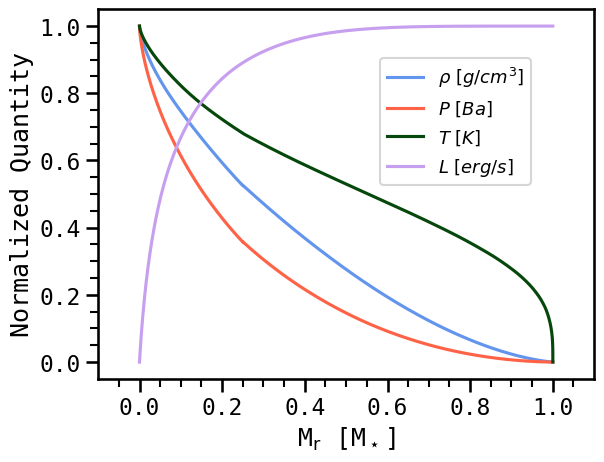

In [61]:
# a figure like 9.1 in HKT but in mass space, y-values near 1

plt.plot(solution[0]/M_star, solution[5]/solution[5].max(), color='cornflowerblue', label=r'$\rho~[g/cm^3]$'.format())
plt.plot(solution[0]/M_star, solution[2]/solution[2].max(), color='tomato', label=r'$P~[Ba]$')
plt.plot(solution[0]/M_star, solution[4]/solution[4].max(), color='xkcd:forest green', label=r'$T~[K]$')
plt.plot(solution[0]/M_star, solution[1]/solution[1].max(), color='xkcd:lavender', label=r'$L~[erg/s]$')

plt.xlabel(r'M$_\mathrm{r}$ [M$_\star$]')
plt.ylabel(r'Normalized Quantity')
plt.legend(fontsize=13, bbox_to_anchor=(0.55,0.5))
plt.xlim(-0.1,1.1)
plt.minorticks_on()

plt.savefig('run_over_mass.png', dpi=150, bbox_inches='tight')

(0.0, 1.1)

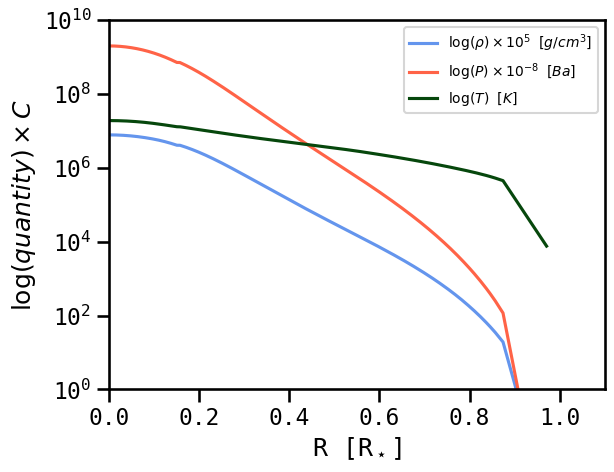

In [54]:
# reproduce figure 9.1 in HKT but in mass space

plt.plot(solution[3]/R_star, solution[5]*1e5, color='cornflowerblue', label=r'$\log(\rho)\times10^5$ $[g/cm^3]$')
plt.plot(solution[3]/R_star, solution[2]*1e-8, color='tomato', label=r'$\log(P)\times10^{-8}$ $[Ba]$')
plt.plot(solution[3]/R_star, solution[4], color='xkcd:forest green', label=r'$\log(T)$ $[K]$')

plt.yscale('log')
plt.xlabel(r'R [R$_\star$]')
plt.ylabel(r'$\log(quantity)\times C$')
plt.legend(fontsize=10)
plt.ylim(1,1e10)
plt.xlim(0,1.1)

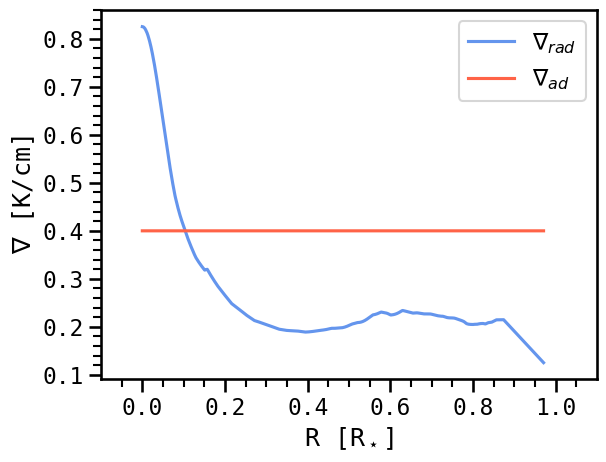

In [62]:
plt.plot(solution[3]/R_star, solution[-1], color='cornflowerblue', label=r'$\nabla_{rad}$')
plt.plot(solution[3]/R_star, np.zeros_like(solution[0])+0.4, color='tomato', label=r'$\nabla_{ad}$')

# plt.yscale('log')
plt.xlabel(r'R [R$_\star$]')
plt.ylabel(r'$\nabla$ [K/cm]')
plt.legend()
# plt.ylim(1,1e10)
plt.xlim(-0.1,1.1)
plt.minorticks_on()
plt.savefig('del_over_mass.png', dpi=150, bbox_inches='tight')


In [63]:
# central density vs avg density
converged_concentration = solution[5].max()/(4*np.pi*M_star/(3*R_star**3))

print("rho_c/rho_avg is", str(round(converged_concentration,2)))

rho_c/rho_avg is 5.94


/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_42570/258114227.py:5: RuntimeWarning: invalid value encountered in power
  return (psi, -np.power(theta, n) - 2 * psi / xi)


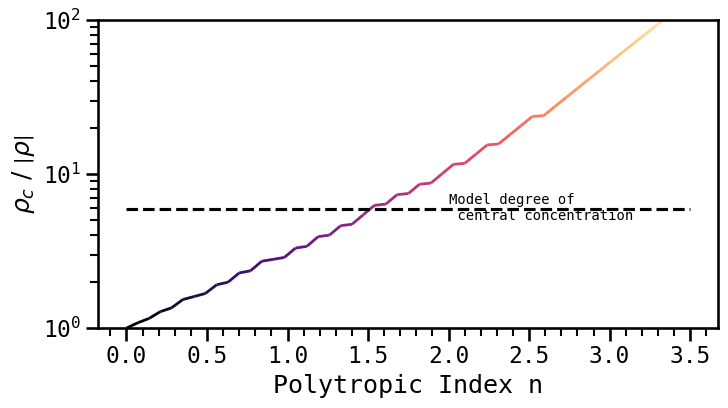

In [88]:
# compare to polytrope

def dtheta(xi, y, n):
    theta, psi = y
    return (psi, -np.power(theta, n) - 2 * psi / xi)

ns = np.linspace(0, 3.5, num=51) # a reasonable number of n for plotting
ts = np.logspace(np.log10(1e-15), np.log10(1000.), num=1000) # dense enough to look smooth

concentrations = np.zeros(ns.shape[0])
for i, n in enumerate(ns):
    soln = solve_ivp(dtheta, [1e-16, 1001.], [1., 0.], args=[n], t_eval=ts)
    # degree of central concentration
    concentration = 1/3 * (soln.t[np.argmin(np.abs(soln.y[0]))]/(-1*soln.y[1][np.argmin(np.abs(soln.y[0]))]))
#     print("for n={}, rho_c/rho_avg is".format(n), str(round(concentration,2)))
    concentrations[i] += concentration

x = ns
y = concentrations
    
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1, figsize=(8,4))

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
from matplotlib.collections import LineCollection
lc = LineCollection(segments, cmap='magma', norm=norm)
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = axs.add_collection(lc)
# cb = fig.colorbar(line, ax=axs)
# cb.ax.set_title('n')
plt.hlines(converged_concentration, 0, 3.5, ls='--', color='k')
plt.annotate('Model degree of \n central concentration', (2,5), fontsize=10)

plt.minorticks_on()
plt.ylim(1, 1e2)
plt.yscale('log')

plt.xlabel('Polytropic Index n')
plt.ylabel(r'$\rho_c~/~\left|\rho\right|}$')

plt.savefig('central_concentration_polytropes.png', dpi=150, bbox_inches='tight')